In [110]:
# Import libraries
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt

In [112]:
# Trigger the authentication flow
ee.Authenticate()

True

In [113]:
# Initialize the library
ee.Initialize()

In [114]:
# initializes the Google Earth Engine API
geemap.ee_initialize()

# Define Functions for customised visualizations

In [115]:
# Define a function for visualizing a single vector layer
def vectormap(layer, viz_params, name):

    """

    """
    map = geemap.Map(center=[12.422777,10.028956], zoom=13)
    map.add_basemap("SATELLITE")
    map.addLayer(layer, vis_params=viz_params, name=name, opacity=0.5)
    return map


In [116]:
# Define a function for visualizing a single raster layer
def rastermap(layer, viz_params, name):

    """

    """
    map = geemap.Map(center=[12.422777,10.028956], zoom=13)
    map.add_basemap("SATELLITE")
    map.addLayer(layer, vis_params=viz_params, name=name)
    return map

In [117]:
# Define a function for visualizing four (4) layers using a linked map 
def linkedmap(layers, viz_params, labels):
    """

    """

    map = geemap.linked_maps(
     rows=2,
     cols=2,
        height="450px",
        center=[12.422777,10.028956],
        zoom=13,
        ee_objects=layers,
        vis_params=viz_params,
        labels=labels,
        label_position="topright",
    )
    return map

In [118]:
# Define a function to visualize two (2) layers using slider Map

def slidermap(layer1params, layer2params):
    """

    """

    ee_object1, vis_params1, name1 = layer1params
    ee_object2, vis_params2, name2 = layer2params
    
    left_layer = geemap.ee_tile_layer(ee_object1, vis_params1, name=name1)
    right_layer = geemap.ee_tile_layer(ee_object2, vis_params2, name=name2)
    
    map = geemap.Map(center=(12.422777,10.028956), zoom =13)

    map.split_map(left_layer, right_layer)
    return map


# Data Downloading and Processing: Boundary Data

In [119]:
# Load the boundary of Haejia
adm2 = ee.FeatureCollection("FAO/GAUL/2015/level2")
hadejia_bdry = adm2.filter(ee.Filter.eq("ADM2_NAME", "Hadejia"))
roi = hadejia_bdry.geometry()

In [120]:
# Visualize the boundary
vectormap(roi, {"fillColor": "00000000", "color": "FF0000"}, "Hadejia Boundary")

Map(center=[12.422777, 10.028956], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

# Data Downloading and Processing: Satellite Images

In [121]:
# Set the start and end dates to search for images
start_date = "2023-02-01"
end_date = "2023-11-30"

Sentinel-2 Level 2A: Bottom-Of-Atmosphere(BOA)/Surface Reflectance

In [122]:
# Define a function that download and process time-series sentinel-2 images
def s2Process(dates, extent, cloud):

    """

    """
    start_date, end_date = dates

    # Load and filter Sentinel-2 image collection 
    def imgDownload():
        
        img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                    .filterDate(start_date, end_date)
                    .filter(ee.Filter.eq('MGRS_TILE', '32PPU'))
                    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                    .filterBounds(extent))

        print(f"There are {img_collection.size().getInfo()} Sentinel-2 Images")
        return img_collection
    
    # function for cloud masking
    def s2ClearSky(image):
      
        scl = image.select('SCL')
        clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(11))
        return image.updateMask(clear_sky_pixels).multiply(0.0001)
    
    # function for resampling 20 meter bands to 10m
    def bandResample(image):
       
        bands_10m = image.select(["B2", "B3", "B4", "B8"])
        bands_20m = image.select(["B5","B6", "B7", "B8A", "B11", "B12"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
        return bands_10m.addBands(bands_20m)


    # function to compute spectral indices
    def indices(image):
        
        ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
        mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
        ndbi = image.normalizedDifference(["B11", "B8"]).rename("ndbi")
        bsi = image.expression(
         "((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))",
            {
                "SWIR1": image.select(["B11"]),
                "RED": image.select(["B4"]),
                "NIR": image.select(["B8"]),
                "BLUE": image.select(["B2"]),
            }
        ).rename("bsi")
        return image.addBands([ndvi, mndwi, ndbi, bsi])
    
    # Donwload the image collection
    s2_collection = imgDownload()

    # Apply the functions to remove clouds, resmaple bands, and compute spectral indices
    s2_collection_resampled = (s2_collection
                           .map(s2ClearSky)
                           .map(bandResample)
                           .map(indices))
    
    # Compute the median composite
    s2_median= s2_collection_resampled.median()

    # Clip the median composite image to the region of interest
    s2_median= s2_median.clip(extent)

    # Check the "s2_median" properties

    # Get the projection information from one of the bands
    s2_median_projection = s2_median.select(0).projection()

    # Get the CRS and spatial resolution
    s2_median_crs = s2_median_projection.crs().getInfo()
    s2_median_scale = s2_median_projection.nominalScale().getInfo()

    print(f"The CRS of s2_median is {s2_median_crs}")
    print(f"The spatial resolution of s2_median is {s2_median_scale}")

    # Check the bands in "s2_median"
    s2_band_names = s2_median.bandNames().getInfo()
    print(f"The following are the bands in 's2_median': {s2_band_names}")


    return s2_median

In [123]:
# Download s2-image collectionn, remove clouds, resmaple bands, compute spectral indices, and median composites
dates = (start_date, end_date)
s2_median_2023 = s2Process(dates, roi, 30)

There are 28 Sentinel-2 Images
The CRS of s2_median is EPSG:4326
The spatial resolution of s2_median is 111319.49079327357
The following are the bands in 's2_median': ['B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'ndvi', 'mndwi', 'ndbi', 'bsi']


In [176]:
# Visualize the "s2_median_2023"
s2_vis_params = {"min":0, "max": 0.3, "bands":["B8", "B4", "B3"], "gamma":0.6}

rastermap(s2_median_2023, s2_vis_params, "S2 Median Composite 2023")


Map(center=[12.422777, 10.028956], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

**Sentinel-1 SAR, instrument mode (IW) GRD: (VV & VH)**

In [125]:
# Define a function that download and process time-series sentinel-1 images

def s1process(dates, extent, radius):
    """
    """
    start_date, end_date = dates

    # Function to load and filter Sentinel-1 image collection 
    def imgdownload():
        img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                .filterDate(start_date, end_date)
                .filter(ee.Filter.eq("instrumentMode", "IW"))
                .filterMetadata("resolution_meters", "equals", 10)
                .filterBounds(extent)
                .select(["VV", "VH"]))

        print(f"There are {img_collection.size().getInfo()} Sentinel-1 Images")

        # Check the available polarizations in the s1_collection
        img_collection_polarizations = img_collection.first().bandNames().getInfo()

        print(f"The following are the polarizations in the Sentinel-1 collection: {img_collection_polarizations}")
        return img_collection

    # Function to apply speckle filter
    def speckle(image):
        image_filtered = image.focal_median(radius, "circle", "meters")
        return image_filtered.copyProperties(image, image.propertyNames())

     # Function to compute VH / VV ratio
    def ratio(image):
        vh = image.select("VH")
        vv = image.select("VV")
        ratio = vh.divide(vv).rename("VH_VV_ratio")
        return image.addBands([ratio])

    # Download the s-1 image collection
    s1_collection = imgdownload()

    # Apply speckle-filter and compute ratio to the S1_collection
    s1_collection_filtered = (s1_collection
                              .map(speckle)
                              .map(ratio))

    # compute median composites
    s1_median =  s1_collection_filtered.median()

    # Clip to the extent
    s1_median = s1_median.clip(extent)


    # Check the "s1_median" properties

    # Get the projection information from one of the bands
    s1_median_projection = s1_median.select(0).projection()

    # Get the CRS and spatial resolution
    s1_median_crs = s1_median_projection.crs().getInfo()
    s1_median_scale = s1_median_projection.nominalScale().getInfo()

    print(f"The CRS of s1_median is {s1_median_crs}")
    print(f"The spatial resolution of s1_median is {s1_median_scale}")

    # Check the bands in "s2_median"
    s1_band_names = s1_median.bandNames().getInfo()
    print(f"The following are the bands in 's1_median': {s1_band_names}")

    return s1_median


In [126]:
# Download s1-image collectionn, apply speckle filter, compute ratio, and median composites
dates = (start_date, end_date)
s1_median_2023 = s1process(dates, roi, 50)

# Select different polarizations from s1_median_2023
s1_median_2023_VH = s1_median_2023.select("VH")
s1_median_2023_VV = s1_median_2023.select("VV")
s1_median_2023_ratio = s1_median_2023.select("VH_VV_ratio")

There are 25 Sentinel-1 Images
The following are the polarizations in the Sentinel-1 collection: ['VV', 'VH']
The CRS of s1_median is EPSG:4326
The spatial resolution of s1_median is 111319.49079327357
The following are the bands in 's1_median': ['VV', 'VH', 'VH_VV_ratio']


In [127]:
# Create a linked Map of Sentinel-1 VH, VH, VH_VV_Ratio, and Sentinel-2 median

# Define a list of layers
layers = [s1_median_2023_VH, s1_median_2023_VV, s1_median_2023_ratio, s2_median_2023]

# Define the visualization parameters
linked_viz_params = [
    {"min":-20, "max":-1, "bands":["VH"], "gamma":1.5},
    {"min":-20, "max":-1, "bands":["VV"], "gamma": 1},
    {"min":0, "max":3, "bands":["VH_VV_ratio"], "gamma": 0.95},
    {"min": 0, "max": 0.3, "bands": ["B4", "B3", "B2"], "gamma": 0.95},
]

# Create labels for the link map
linked_labels = [
    "Sentinel-1 (VV Median)",
    "Sentinel-1 (VH Median)",
    "Sentinel-1 (VH_VV Ratio)",
    "Sentinel-2 (Median)"
]

# Visualize the layers
linkedmap(layers, linked_viz_params, linked_labels)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

# Layer Stacking / Band Composite

In [128]:
stacked_layer = s2_median_2023.addBands(s1_median_2023_VH).addBands(s1_median_2023_VV).addBands(s1_median_2023_ratio) 
print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")

The bands in the stacked layer are: ['B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'ndvi', 'mndwi', 'ndbi', 'bsi', 'VH', 'VV', 'VH_VV_ratio']


In [129]:
# Check the properties of the "stacked_layer"

# Get the projection information from one of the bands
stacked_layer_projection = stacked_layer.select(16).projection()

# Get the CRS and spatial resolution
stacked_layer_crs = stacked_layer_projection.crs().getInfo()
stacked_layer_scale = stacked_layer_projection.nominalScale().getInfo()

print(f"The CRS of the stacked_layer is {stacked_layer_crs}")
print(f"The spatial resolution of the stacked_layer is {stacked_layer_scale}")

The CRS of the stacked_layer is EPSG:4326
The spatial resolution of the stacked_layer is 111319.49079327357


# Training and Testing

**LAND COVER CLASSES**

S_N	    Label			        Class

1	    Bare soil		        1

2	    Built-up		        2

3	    Cropland		        3

4	    Tree & Grass		    4	

5	    Water & Wetland	        5		


In [130]:
# Load the training and testing data
sample_gdf = gpd.read_file("Data\Training_Testing_Samples_2023_WGS84.shp")

sample_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Label     1449 non-null   object  
 1   Class     1449 non-null   int64   
 2   geometry  1449 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 34.1+ KB


In [131]:
sample_gdf["Class"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1449 entries, 0 to 1448
Series name: Class
Non-Null Count  Dtype
--------------  -----
1449 non-null   int64
dtypes: int64(1)
memory usage: 11.4 KB


In [132]:
# Check the training samples
sample_gdf.head()

,Label,Class,geometry
0,Tree,4,POINT (10.03267 12.44483)
1,Tree,4,POINT (10.03637 12.44241)
2,Tree,4,POINT (10.03006 12.44659)
3,Tree,4,POINT (10.03033 12.44791)
4,Tree,4,POINT (10.03325 12.44103)


In [133]:
# Visualize the samples on a map and symbolize them with different colour for the unique ID

palette = {
    1: "#c4734a", 
    2: "#e31a1c", 
    3: "#fae500", 
    4: "#219f45", 
    5: "#1452d9"}

# Create a dictionary to map IDs to colors
unique_ids = np.sort(sample_gdf["Class"].unique())
id_color_map = {unique_id: palette.get(unique_id, "#808080") for unique_id in unique_ids}

# Initialize the folium map
center = sample_gdf.geometry.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=13)

# Add satellite basemap
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite",
    overlay=True,
).add_to(m)

# Add points to the map
for idx, row in sample_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color=id_color_map[row["Class"]],
        fill=True,
        fill_color=id_color_map[row["Class"]],
        fill_opacity=0.6,
        popup=f"ID: {row['Class']}, Class: {row['Label']}"
    ).add_to(m)

# Display the map
m

In [134]:
# Sample Class Distribution
count = sample_gdf["Class"].value_counts().sort_values(ascending=False)
per = ((count / len(sample_gdf)) * 100).round(2)

# Create a DataFrame for better display
count_per = pd.DataFrame({
    'Class': count.index,
    'Count': count.values,
    'Percentage': per.values
})

print(count_per)

   Class  Count  Percentage
0      3    610       42.10
1      2    458       31.61
2      1    151       10.42
3      5    134        9.25
4      4     96        6.63


In [135]:
# Convert sample_gdf to GEE feature collection
sample_ee_all = geemap.gdf_to_ee(sample_gdf)
print(sample_ee_all.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [10.032671687128945, 12.4448289016757]}, 'id': '0', 'properties': {'Class': 4, 'Label': 'Tree'}}


In [136]:
# Define a function to split the sample randomly to training and testing and extract the image properties to the points
def traintest(sample, image, threshold):
    
    """
    """

    # Add random column to the collection
    sample_random = sample.randomColumn("random")

    # Split samples to training and testing
    training_set = sample_random.filter(ee.Filter.lt("random", threshold))
    testing_set = sample_random.filter(ee.Filter.gte("random", threshold))

    # Extracting the (spectral) properties of the bands in the layers to the training points
    training = image.sampleRegions(
        collection= training_set,
        properties = ["Class"],
        scale=10
    )

    
    return training, testing_set 

In [137]:
# Apply the function to generate training and testing samples (70, 30)
training, testing = traintest(sample_ee_all, stacked_layer, 0.7)

# Extract unique "Classes" values from the training set
training_ids = training.aggregate_array("Class").distinct()
training_ids_list = training_ids.getInfo()

# Extract unique "Classes" values from the testing set
testing_ids = testing.aggregate_array("Class").distinct()
testing_ids_list = testing_ids.getInfo()

# Inspecting the results
print("Training Set Example:")
print(training.first().getInfo())
print("Unique Classes in Training Set:", training_ids_list)

print("Testing Set Example:")
print(testing.first().getInfo())
print("Unique Classes in Testing Set:", testing_ids_list)


Training Set Example:
{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'B11': 0.35683125000000004, 'B12': 0.293675, 'B2': 0.052000000000000005, 'B3': 0.09620000000000001, 'B4': 0.11120000000000001, 'B5': 0.26279375000000005, 'B6': 0.31019375, 'B7': 0.33038750000000006, 'B8': 0.328, 'B8A': 0.35443125000000003, 'Class': 4, 'VH': -16.402238574478567, 'VH_VV_ratio': 1.7973659666974189, 'VV': -9.216517419477746, 'bsi': 0.09825082766351242, 'mndwi': -0.5840951800346375, 'ndbi': 0.059081509709358215, 'ndvi': 0.49904605746269226}}
Unique Classes in Training Set: [4, 5, 2, 1, 3]
Testing Set Example:
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [10.036370490926965, 12.442408651067458]}, 'id': '1', 'properties': {'Class': 4, 'Label': 'Tree', 'random': 0.7358330923251438}}
Unique Classes in Testing Set: [4, 5, 2, 1, 3]


## Classification And Accuracy Assessment

### Random Forest Algorithm

In [138]:
# Define a function for training, testing, and classification with Random Forests (RF)

def rf(parameters, image, training, testing, out_folder, out_file_base):

    """
    
    """
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    # Define the CSV file paths
    error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
    importance_file_name = os.path.join(out_folder, out_file_base + "feature_importance" + ".csv")

    # Instatiate the RandomForest (RF) classifier 
    trees, split, leaf, bag, node, seed = parameters

    model = (ee.Classifier.smileRandomForest(
            numberOfTrees=trees,
            variablesPerSplit=split,
            minLeafPopulation= leaf,
            bagFraction= bag, 
            maxNodes= node,
            seed= seed, 
            )
    )
    
    # Train the RF model with the training set
    classifier = model.train(
        features= training,  
        classProperty= "Class", 
        inputProperties= image.bandNames()
        )


    # Perform classification using the Random Forest(RF) algorithm
    classified = image.classify(classifier)

    
    # Extract the corresponding values of the testing points from the classified image
    validation = (classified.sampleRegions(
        collection= testing,
        properties= ["Class"],
        scale=10
        )
    )


    # Get the error matrix 
    error_matrix = validation.errorMatrix(
    actual="Class", 
    predicted= "classification")

    # Extract the error matrix to a dataframe

    # Extract data from error matrix
    error_matrix_array = error_matrix.array().getInfo()

    # Prepare data for DataFrame (excluding the first row and column)
    data = [row[1:] for row in error_matrix_array[1:]]  
    # Define column names based on the first row (excluding the first element)
    columns = ["Bare soil", "Built-up", "Cropland", "Tree & Grass", "Water & Wetland"]

    # Create DataFrame for the error matrix
    error_matrix_df = pd.DataFrame(data, columns=columns)
    error_matrix_export = error_matrix_df.to_csv(error_file_name, index=False)

    # Print the accuracy results
    print("Confusion matrix for Random Forest:\n", error_matrix_df)
    print("Overall Accuracy for Random Forest:", round(error_matrix.accuracy().getInfo(),3)) 
    print("Producers Accuracy for Random Forest:", error_matrix.producersAccuracy().getInfo()) 
    print("Consumers Accuracy for Random Forest:", error_matrix.consumersAccuracy().getInfo())
    print("Kappa for Random Forest:", round(error_matrix.kappa().getInfo(), 3))

    # Get feature importance and values from the classifier
    explained = classifier.explain()
    importance = ee.Dictionary(explained.get("importance"))
    feature_names = importance.keys().getInfo()
    importance_values = importance.values().getInfo()

   
     # Combine the feature names and values
    importance_combined = pd.Series(importance_values, index=feature_names).reset_index()
    importance_combined.to_csv(importance_file_name, index=False)

    return classified, error_file_name, importance_file_name

**RF: Default Parameters** 

In [139]:
# Apply the rf function using the default parameters
# Define the RF parameters (default)
rf_def_parameters = (10, None, 1, 0.5, None, 0)

# Perform the classification with the default parameters of RF and print accuracy results
rf_def_classification, rf_def_confusion_path, rf_def_fea_importance_path = rf(rf_def_parameters, stacked_layer, training, testing, "Outputs", "rf_def_classification_")

Confusion matrix for Random Forest:
    Bare soil  Built-up  Cropland  Tree & Grass  Water & Wetland
0         24         5         8             0                0
1          2       127        10             2                1
2          2         5       182             1                3
3          1         1         2            23                0
4          0         3         1             1               31
Overall Accuracy for Random Forest: 0.89
Producers Accuracy for Random Forest: [[0], [0.6486486486486487], [0.8943661971830986], [0.9430051813471503], [0.8518518518518519], [0.8611111111111112]]
Consumers Accuracy for Random Forest: [[0, 0.8275862068965517, 0.900709219858156, 0.896551724137931, 0.8518518518518519, 0.8857142857142857]]
Kappa for Random Forest: 0.836


In [179]:
# Visualize the result of the Land Cover using RF (Default) and Compare it with the original s-2 image using slider Map
lc_vis_params = {"min": 1, "max":5, "palette" : ["#c4734a", "#e31a1c", "#fae500", "#219f45", "#1452d9"]}
s2_vis_params_rgb =  {"min": 0, "max": 0.3, "bands": ["B4", "B3", "B2"], "gamma": 0.7}

s2_params =(
    s2_median_2023,
    s2_vis_params_rgb,
   "Sentinel-2 (Median)")

rf_def_lc_params = (
    rf_def_classification,
    lc_vis_params,
    "Land Cover (RF DEFAULT)")

slidermap(s2_params, rf_def_lc_params)

Map(center=[12.422777, 10.028956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

**RF: Hyper-Parameter Tuning**

In [141]:
# Apply the rf function using tuned parameters

# Reference for parameter values:https://doi.org/10.1080/15481603.2019.1650447
rf_tun_parameters = (1000, 7, None, None, None, None)

# Reference for parameter values: https://doi.org/10.3390/rs14051189
#rf_tun_parameters = (150, 3, None, 0.1, None, None)

# Perform the classification with the default parameters of RF and print accuracy results
rf_tun_classification, rf_tun_confusion_path, rf_tun_fea_importance_path = rf(rf_tun_parameters, stacked_layer, training, testing, "Outputs", "rf_tun_classification_")

Confusion matrix for Random Forest:
    Bare soil  Built-up  Cropland  Tree & Grass  Water & Wetland
0         22         2        13             0                0
1          3       127        11             1                0
2          2         3       185             0                3
3          0         2         1            24                0
4          1         0         0             2               33
Overall Accuracy for Random Forest: 0.899
Producers Accuracy for Random Forest: [[0], [0.5945945945945946], [0.8943661971830986], [0.9585492227979274], [0.8888888888888888], [0.9166666666666666]]
Consumers Accuracy for Random Forest: [[0, 0.7857142857142857, 0.9477611940298507, 0.8809523809523809, 0.8888888888888888, 0.9166666666666666]]
Kappa for Random Forest: 0.849


In [142]:
# Visualize the result of the Land Cover using RF (Tuned) and Compare it with the original s-2 image using slider Map
lc_vis_params = {"min": 1, "max":5, "palette" : ["#c4734a", "#e31a1c", "#fae500", "#219f45", "#1452d9"]}

s2_params =(
    s2_median_2023,
    s2_vis_params,
    "Sentinel-2 (Median)")

rf_tun_lc_params = (
    rf_tun_classification,
    lc_vis_params,
    "Land Cover (RF TUNED)")

slidermap(s2_params, rf_tun_lc_params)

Map(center=[12.422777, 10.028956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

**Support Vector Machines (SVM)**

In [143]:
# Define a function for training, testing, and classification with Support Vector Machines (SVM)

def svm(parameters, image, training, testing, out_folder, out_file_base):
    """

    """

    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    # Define the CSV file paths
    error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")

    # Instatiate the Support Vector Machines (SVM) classifier 

    kernelType, gamma, cost = parameters

    model = ee.Classifier.libsvm(
        kernelType= kernelType,
        gamma= gamma,
        cost=cost
    )
    
    # Train the SVM model with the training set
    classifier = (model.train(
        features= training,  
        classProperty= "Class", 
        inputProperties= image.bandNames()
        )
    )

    # Perform classification using the SVM algorithm
    classified = image.classify(classifier).clip(roi)
    
    # Extract the corresponding values of the testing points from the classified image
    validation = (classified.sampleRegions(
        collection= testing,
        properties= ["Class"],
        scale=10
        )
    )

    # Get the error matrix 
    error_matrix = validation.errorMatrix(
    actual="Class", 
    predicted= "classification")


    # Extract the error matrix to a dataframe

    # Extract data from error matrix
    error_matrix_array = error_matrix.array().getInfo()

    # Prepare data for DataFrame (excluding the first row and column)
    data = [row[1:] for row in error_matrix_array[1:]]  
    # Define column names based on the first row (excluding the first element)
    columns = ["Bare soil", "Built-up", "Cropland", "Tree & Grass", "Water & Wetland"]

    # Create DataFrame for the error matrix
    error_matrix_df = pd.DataFrame(data, columns=columns)
    error_matrix_export = error_matrix_df.to_csv(error_file_name, index=False)

     # Print the accuracy results
    print("Confusion matrix for SVM:\n", error_matrix_df)
    print('Overall Accuracy for SVM:', round(error_matrix.accuracy().getInfo(), 3)) 
    print('Producers Accuracy for SVM:', error_matrix.producersAccuracy().getInfo())
    print('Consumers Accuracy for SVM:', error_matrix.consumersAccuracy().getInfo())
    print('Kappa for SVM:', round(error_matrix.kappa().getInfo(), 3))


    return classified, error_matrix_export

**SVM: Default Parameters** 

In [181]:
# Define the SVM parameters (default)
svm_def_parameters = ("LINEAR", None, 1)

# Perform the classification with the default parameters of SVM
svm_def_classification, svm_def_confusion_path= svm(svm_def_parameters, stacked_layer, training, testing, "Outputs", "svm_def_classification_")

Confusion matrix for SVM:
    Bare soil  Built-up  Cropland  Tree & Grass  Water & Wetland
0         16        12         9             0                0
1          1       108        31             2                0
2          0         5       187             0                1
3          0         2        11            14                0
4          0         4         2             2               28
Overall Accuracy for SVM: 0.811
Producers Accuracy for SVM: [[0], [0.43243243243243246], [0.7605633802816901], [0.9689119170984456], [0.5185185185185185], [0.7777777777777778]]
Consumers Accuracy for SVM: [[0, 0.9411764705882353, 0.8244274809160306, 0.7791666666666667, 0.7777777777777778, 0.9655172413793104]]
Kappa for SVM: 0.708


In [182]:
# Visualize the result of the Land Cover using SVM (Default) using slider Map
lc_vis_params = {"min": 1, "max":5, "palette" : ["#c4734a", "#e31a1c", "#fae500", "#219f45", "#1452d9"]}

s2_params =(
    s2_median_2023,
    s2_vis_params,
    "Sentinel-2 (Median)")

svm_def_lc_params = (
    svm_def_classification,
    lc_vis_params,
    "Land Cover (SVM DEFAULT)")

slidermap(s2_params, svm_def_lc_params)

Map(center=[12.422777, 10.028956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

**SVM: Hyper-Parameter Tuning**

In [146]:
# Define the SVM parameters (Tuned)
# Reference for parameter values:https://doi.org/10.1080/15481603.2019.1650447
#svm_tun_parameters = ("RBF", 0.225, 24)

svm_tun_parameters = ("RBF", 0.1105, 64)

# Perform the classification with the tuned parameters of SVM
svm_tun_classification, svm_tun_confusion_path= svm(svm_tun_parameters, stacked_layer, training, testing, "Outputs", "svm_tun_classification_")

Confusion matrix for SVM:
    Bare soil  Built-up  Cropland  Tree & Grass  Water & Wetland
0         26         3         8             0                0
1          4       119        11             6                2
2          1         4       183             1                4
3          0         4         3            20                0
4          2         2         0             2               30
Overall Accuracy for SVM: 0.869
Producers Accuracy for SVM: [[0], [0.7027027027027027], [0.8380281690140845], [0.9481865284974094], [0.7407407407407407], [0.8333333333333334]]
Consumers Accuracy for SVM: [[0, 0.7878787878787878, 0.9015151515151515, 0.8926829268292683, 0.6896551724137931, 0.8333333333333334]]
Kappa for SVM: 0.806


In [147]:
# Visualize the result of the Land Cover using SVM (Default) using slider Map
lc_vis_params = {"min": 1, "max":5, "palette" : ["#c4734a", "#e31a1c", "#fae500", "#219f45", "#1452d9"]}

s2_params =(
    s2_median_2023,
    s2_vis_params,
    "Sentinel-2 (Median)")

svm_tun_lc_params = (
    svm_tun_classification,
    lc_vis_params,
    "Land Cover (SVM TUNED PARAMS)")

slidermap(s2_params, svm_tun_lc_params)

Map(center=[12.422777, 10.028956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [180]:
# Visualize the four results using a linked map
# Create a linked Map of rf_def, rf_tun, svm_def, svm_tun

# Define a list of layers
lc_layers = [rf_def_classification, rf_tun_classification, s2_median_2023, svm_tun_classification] #svm_def_classification

# Define the visualization parameters
lc_viz_params = [
    lc_vis_params,
    lc_vis_params,
    s2_vis_params_rgb,
    lc_vis_params,
]

# Create labels for the link map
lc_labels = [
    "RF (Default)",
    "RF (Tuned)",
    "Sentinel-2 (Median Composite)",
    "SVM (Tuned)"
]

# Visualize the layers
linkedmap(lc_layers, lc_viz_params, lc_labels)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [149]:
# Load in ESA Global land cover data
esa_lC = ee.ImageCollection('ESA/WorldCover/v200').first().clip(roi)
vis_lc = {"bands": ['Map']}

In [184]:
# Visualize ESA land cover with the best performance 
esa_params =(
    esa_lC,
    vis_lc,
   "Land Cover (ESA GLOBAL)")

rf_def_lc_params = (
    rf_def_classification,
    lc_vis_params,
    "Land Cover (RF DEFAULT)")

slidermap(esa_params, rf_def_lc_params)

Map(center=[12.422777, 10.028956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Area Estimation and Export Results

In [150]:
import os
import geopandas as gpd
import geemap

def rasterConvert(layer, out_folder, out_file_base):
    """
    Converts a GEE raster layer to a vector, dissolves by 'label', adds area, and exports as both a shapefile and a CSV.
    """
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    
    # Define shapefile and CSV file paths
    shp_file_name = os.path.join(out_folder, out_file_base + ".shp")
    csv_file_name = os.path.join(out_folder, out_file_base + ".csv")

    # Convert raster to vector
    vector = layer.reduceToVectors(
        geometry=roi,
        crs="EPSG:32632",
        scale=10,
        geometryType='polygon',
        bestEffort=True,
        maxPixels=1e8,
    )
    
    # Convert the ee vector to shapefile
    geemap.ee_to_shp(vector, shp_file_name)
    
    # Read the shapefile into a GeoDataFrame
    shp = gpd.read_file(shp_file_name)

    # Ensure the 'label' column is present before dissolving
    if 'label' not in shp.columns:
        raise KeyError("'label' column is not present in the shapefile.")
    
    # Dissolve the shapefile by 'label'
    shp_disv = shp.dissolve(by="label", as_index=False)
    shp_disv = shp_disv.to_crs("EPSG:32632")
    
    # Add Area attribute to the dissolved shapefile
    shp_disv["Area_km2"] = shp_disv.geometry.area / 1e6 
    
    # Select the relevant columns for shapefile export
    shp_disv_vector = shp_disv[["geometry", "Area_km2", "label"]]
    
    # Select the relevant columns for CSV export
    shp_disv_csv = shp_disv[["Area_km2", "label"]]

    # Export the shapefile
    shp_disv_vector.to_file(shp_file_name, driver='ESRI Shapefile')

    # Export the CSV
    shp_disv_csv.to_csv(csv_file_name, index=False)
    
    return shp_disv_vector, shp_disv_csv


In [157]:
# Export the land cover classification as vector files and CSV files
lc_layers = [rf_def_classification, rf_tun_classification, svm_def_classification, svm_tun_classification]
output_files = ["rf_def_classification", "rf_tun_classification", "svm_def_classification", "svm_tun_classification"]

export_list = pd.Series(lc_layers, output_files)

for layer_name, layer in export_list.items():
    rasterConvert(layer, "Outputs", layer_name)



In [158]:
# Function to export the GEE layer to tif raster

def exportLC(layer, out_folder, out_file):
    """
    """
    try:
        if not os.path.exists (out_folder):
            os.mkdir(out_folder)
        file = os.path.join(out_folder, out_file)

        raster = geemap.ee_export_image(
            layer,
            file,
            scale=10,
            region= roi,
            crs= "EPSG:32632",
            file_per_band=False
        )
        return raster
    except Exception as e:
        print("An error has occured", e)

In [165]:
# Export the land cover classification as raster layers
lc_layers = [s2_median_2023.select(["B2", "B3", "B4", "B8"]).clip(roi), rf_def_classification, rf_tun_classification, svm_def_classification, svm_tun_classification]
ouput_files = ["s2_median_2023.tif", "rf_def_classification.tif", "rf_tun_classification.tif", "svm_def_classification.tif", "svm_tun_classification.tif"]

export_list = pd.Series(lc_layers, ouput_files)

for f, l in export_list.items():
    exportLC(l, "Outputs", f)


Generating URL ...
Please wait ...
Data downloaded to d:\Lukumon_Projects\Land-Cover-Classification-Using_Machine-Learning_Algorithms-and-Multi-Source-Satellite-Images\Outputs\s2_median_2023.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Lukumon_Projects\Land-Cover-Classification-Using_Machine-Learning_Algorithms-and-Multi-Source-Satellite-Images\Outputs\rf_def_classification.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Lukumon_Projects\Land-Cover-Classification-Using_Machine-Learning_Algorithms-and-Multi-Source-Satellite-Images\Outputs\rf_tun_classification.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Generating URL ...
Please wait ...
An error occurred while downloading.


# Accuracy Comparison

# Features Importance

In [162]:
def featureDisplay(path):
    """
    """

    df= pd.read_csv(path, index_col=False)

    df.rename(columns={
        "index" : "Feature",
        "0" : "Importance"
    }, inplace=True)

    df= df.sort_values(by="Importance", ascending=False)

    # Plotting the feature importance as a horizontal bar chart
    fig, ax = plt.subplots(1, figsize=(12, 8))
    plt.barh("Feature", "Importance", data=df, color="skyblue")
    plt.xlabel("Importance", fontweight = "bold")
    plt.ylabel("Feature", fontweight = "bold")
    plt.title("Feature Importance for Random Forest", fontweight = "bold")
    plt.gca().invert_yaxis()  
    plt.show()  

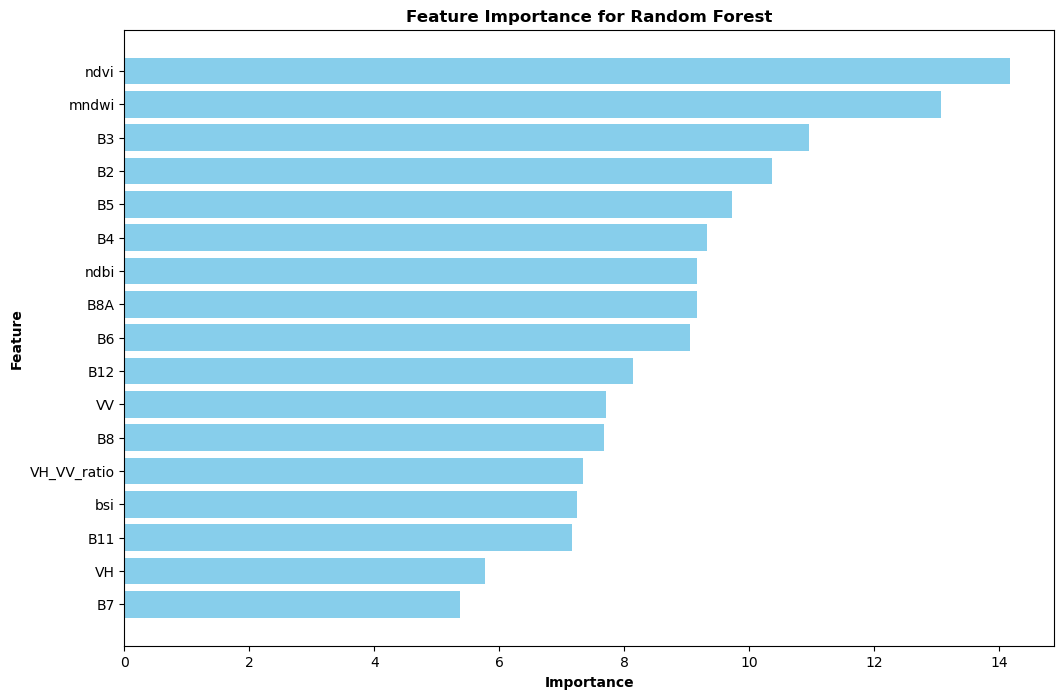

In [163]:
featureDisplay(rf_def_fea_importance_path)

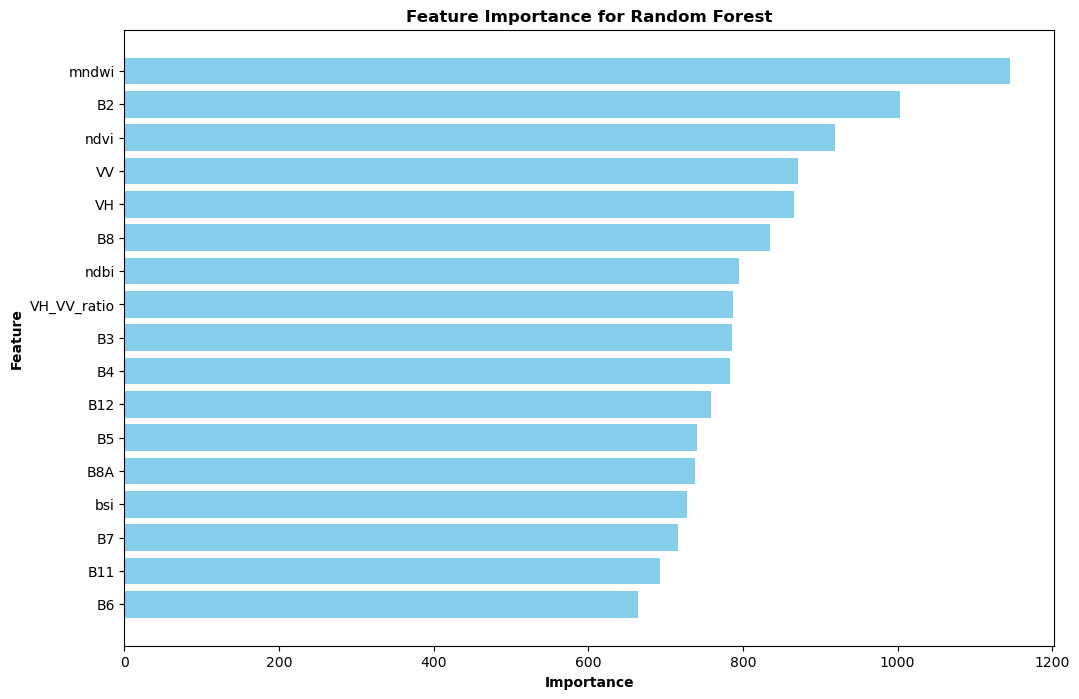

In [164]:
featureDisplay(rf_tun_fea_importance_path)